<a href="https://colab.research.google.com/github/ZhenwenZhang1108/ADL3_PartB/blob/main/PartB_%E8%A1%A5%E5%85%853.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torcheval

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 3.2 MB/s eta 0:00:00


In [2]:
import sklearn
from sklearn.metrics import f1_score
import torch
import torch.nn as nn
import torch.utils
import torch.optim as optim
import torch
from torch.utils.data import Dataset,DataLoader,random_split
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from torch.nn import functional as F
from torchvision.datasets.utils import download_url
from torch import Tensor
from sklearn.preprocessing import OneHotEncoder
from torcheval.metrics.functional import multiclass_f1_score
from google.colab import drive
from torcheval.metrics.functional.classification import binary_recall,multiclass_recall
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
import os
path = "/content/drive/MyDrive/adl3/"
os.chdir(path)
print(os.listdir())

['model_lstm1.pth', 'model_rnn1.pth', 'distribution.png', 'lstm_distribution.png', 'Rnn_distribution.png', 'wandb']


In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cpu


创建数据库(list存两个各自的数组？一个数组里装x,另一个装y?，还是必须构建x到y的一一对应关系)。
为每段序列添加一个标签（打标签的规则是什么？总不能随机打标签吧）。

对序列进行编码，abc的话采用One-hot编码应该可以。

对序列进行编码，只有abc三个字母的话采用One-hot编码应该可以。是否需要补齐<padding>？

如果我们设置batch size=1，那就不需要padding了？？？
但如此设置，恐怕挨个挪到GPU上就会很慢了，可能就得在CPU上直接训练？

In [ ]:
stats = np.zeros((2,18))
print(stats)

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [ ]:

#自定义一个Dataset类，必需包含init, len, getitem
class CustomDataset(Dataset):
    def __init__(self):
        self.data = []
        self.targets = []

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        return self.data[index], self.targets[index]

    def append(self, data, target):
        self.data.append(data)
        self.targets.append(target)

# 创建自定义数据集对象
dataset = CustomDataset()
sum = 0
k=0
# 逐个添加数据和标签
for x in range(1,19):
  for y in range(1,19):
    for z in range(1,19):
     if x+y+z>20:
       continue
     input_string = 'a'*x + 'b'*y + 'c'*z
     sum+=1
     input_array = np.array(list(input_string)).reshape(-1, 1)
     #创建并适配 OneHotEncoder
     encoder = OneHotEncoder(sparse_output=False)
     data = torch.FloatTensor(encoder.fit_transform(input_array))
     if x==y or y==z or x==z :
      target=torch.tensor(1)
      k+=1
      stats[1][x+y+z-3] += 1
     else:
      target=torch.tensor(0)
      stats[0][x+y+z-3] += 1
     dataset.append(data, target)

batch_size = 1
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

print(next(iter(dataloader))[1])
print(k)
print(stats[0])
print(stats[1])

tensor([1])
258
[  0.   0.   0.   6.   6.  12.  18.  24.  30.  42.  48.  60.  72.  84.
  96. 114. 126. 144.]
[ 1.  3.  6.  4.  9.  9. 10. 12. 15. 13. 18. 18. 19. 21. 24. 22. 27. 27.]


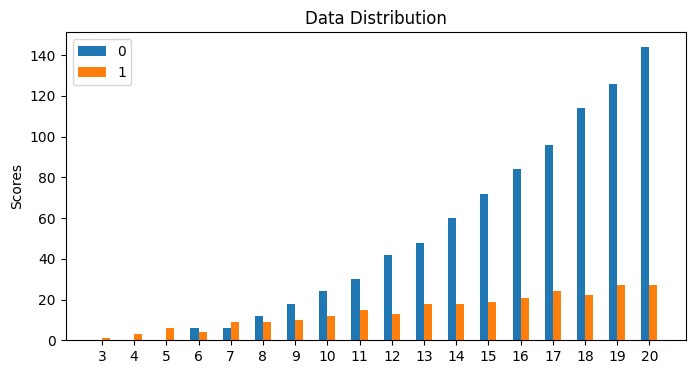

In [ ]:
x_label = list()
for x in range(3,21):
  x_label.append(str(x))

plt.figure(figsize=(8, 4))

x = np.arange(len(x_label))  # x轴刻度标签位置
width = 0.25  # 柱子的宽度
# 计算每个柱子在x轴上的位置，保证x轴刻度标签居中
# x - width/2，x + width/2即每组数据在x轴上的位置
plt.bar(x - width/2, stats[0], width, label='0')
plt.bar(x + width/2, stats[1], width, label='1')
plt.ylabel('Scores')
plt.title('2 datasets')
plt.xticks(x, labels=x_label)
plt.legend()
plt.title("Data Distribution")
plt.savefig("./distribution.png")

In [ ]:
print(dataset[11][0].shape)
print(dataset[12][0].shape)
print(dataset[13][0].shape)

torch.Size([14, 3])
torch.Size([15, 3])
torch.Size([16, 3])


In [22]:
def train_model(model, train_loader, criterion, optimizer, num_epochs):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0
        for texts, labels in train_loader:
            # 前向传播
            outputs = model(texts)
            loss = criterion(outputs, labels)

            # 反向传播和优化
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}')

In [23]:
def eval_model(model,test_loader):
    model.eval()
    input = torch.tensor([])
    target = torch.tensor([])
    accstat = np.zeros((2,18))
    sta = np.zeros((2,18))
    with torch.no_grad():
      for texts, labels in test_loader:
          outputs = model(texts)
          predicted = torch.argmax(outputs,1)
          sta[labels.item()][texts.size(1)-3]+=1
          if predicted == labels:
            accstat[labels.item()][texts.size(1)-3]+=1
          input = torch.cat((input,predicted))
          target = torch.cat((target,labels))
    input = input.numpy()
    target = target.numpy()
    accuracy = 100 * (input == target).sum() / len(target)
   ## recall = binary_recall(input, target)
    f1score = f1_score(y_pred=input,y_true=target)
    print(f'Validation Accuracy: {accuracy:.2f}%')
    print(f'Validation F1 score: {f1score:.2f}')
    #sta里会有爆零的可能
    return accstat/sta, accuracy, f1score

RNN模型建立
https://pytorch.org/docs/stable/generated/torch.nn.RNN.html

In [20]:
class RNNClassifier(nn.Module):
    def __init__(self, nlayers=1, embed_size=3, hidsize=10, bidirect=False, output_size=2):
        super(RNNClassifier, self).__init__()
        #one-hot编码，字母本身没有额外信息需要学习，所以不需要embedding层??
        self.embed = nn.Linear(in_features=embed_size,out_features=hidsize)
        self.rnn = nn.RNN(input_size=hidsize, num_layers=nlayers, hidden_size=hidsize, bidirectional=bidirect, batch_first=True)
        if bidirect==True:
          self.bi=2
        else:
          self.bi=1
        self.fc = nn.Linear(hidsize*self.bi*nlayers,output_size)
    def forward(self, x):
        x= self.embed(x)
        output,h_n = self.rnn(input=x)
        h_n = h_n.permute(1,0,2) #这里要小心，即使开了batch_first=True,第一个维度上也不是batch_size，这是pytorch.RNN的设定
        h_n = torch.flatten(h_n,start_dim=-2)
        out = self.fc(h_n)
        return out #注意这里的output没做softmax

In [24]:
model_rnn = RNNClassifier(hidsize=100, bidirect=True).to(device)
criterion_CE = nn.CrossEntropyLoss() #自带softmax
optimizer_adam = optim.Adam(model_rnn.parameters(), lr=0.001)

x = torch.rand(6,11,3) #(batch_size,seq_len,embed_size)
y = model_rnn(x)
z = torch.argmax(y,1)
print(z.shape)

torch.Size([6])


In [ ]:
train_size = int(0.7 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

trainloader = DataLoader(train_dataset, batch_size=1, shuffle=True)
testloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

print(len(trainloader))
print(len(testloader))

798
342


In [ ]:
# 训练模型
train_model(model=model_rnn, train_loader=trainloader, criterion=criterion_CE, optimizer = optimizer_adam, num_epochs=20)
# 测试模型


Epoch [1/20], Loss: 0.5743
Epoch [2/20], Loss: 0.5297
Epoch [3/20], Loss: 0.5201
Epoch [4/20], Loss: 0.5081
Epoch [5/20], Loss: 0.5037
Epoch [6/20], Loss: 0.5061
Epoch [7/20], Loss: 0.5096
Epoch [8/20], Loss: 0.4979
Epoch [9/20], Loss: 0.5164
Epoch [10/20], Loss: 0.4931
Epoch [11/20], Loss: 0.5244
Epoch [12/20], Loss: 0.5320
Epoch [13/20], Loss: 0.5181
Epoch [14/20], Loss: 0.4710
Epoch [15/20], Loss: 0.4809
Epoch [16/20], Loss: 0.4604
Epoch [17/20], Loss: 0.4311
Epoch [18/20], Loss: 0.4221
Epoch [19/20], Loss: 0.4227
Epoch [20/20], Loss: 0.4238


In [ ]:
eval_model(model_rnn,testloader)
torch.save(model_rnn.state_dict(), './model_rnn1.pth')

Validation Accuracy: 83.33%
Validation F1 score: 0.45
(342,)
(342,)


LSTM模型
https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html

In [21]:
class LSTMClassifier(nn.Module):
    def __init__(self, nlayers=1, embed_size=3, hidsize=100, bidirect=False, output_size=2):
        super(LSTMClassifier, self).__init__()
        self.embed = nn.Linear(in_features=embed_size,out_features=hidsize)
        self.lstm = nn.LSTM(input_size=hidsize, num_layers=nlayers, hidden_size=hidsize, bidirectional=bidirect, batch_first=True)
        if bidirect==True:
          self.bi=2
        else:
          self.bi=1
        self.fc = nn.Linear(hidsize*self.bi*nlayers,output_size)
    def forward(self, x):
        x = self.embed(x)
        output, (h_n, c_n) = self.lstm(input=x)
        h_n = h_n.permute(1,0,2) #这里要小心，即使开了batch_first=True,第一个维度上也不是batch_size，这是pytorch.RNN的设定
        h_n = torch.flatten(h_n,start_dim=-2)
        out = self.fc(h_n)
        return out #注意这里的output没做softmax

In [25]:
model_lstm = LSTMClassifier().to(device)
criterion_CE = nn.CrossEntropyLoss() #自带softmax
optimizer_adam = optim.Adam(model_lstm.parameters(), lr=0.001)

x = torch.rand(6,11,3) #(batch_size,seq_len,embed_size)
y = model_lstm(x)
z = torch.argmax(y,1)
print(z.shape)

torch.Size([6])


In [ ]:
train_model(model=model_lstm, train_loader=trainloader, criterion=criterion_CE, optimizer = optimizer_adam, num_epochs=20)
# 测试模型

Epoch [1/20], Loss: 0.5399
Epoch [2/20], Loss: 0.5217
Epoch [3/20], Loss: 0.5114
Epoch [4/20], Loss: 0.4941
Epoch [5/20], Loss: 0.4876
Epoch [6/20], Loss: 0.4608
Epoch [7/20], Loss: 0.4437
Epoch [8/20], Loss: 0.3989
Epoch [9/20], Loss: 0.3743
Epoch [10/20], Loss: 0.3530
Epoch [11/20], Loss: 0.3404
Epoch [12/20], Loss: 0.3183
Epoch [13/20], Loss: 0.2957
Epoch [14/20], Loss: 0.2517
Epoch [15/20], Loss: 0.1719
Epoch [16/20], Loss: 0.1429
Epoch [17/20], Loss: 0.0928
Epoch [18/20], Loss: 0.0856
Epoch [19/20], Loss: 0.0330
Epoch [20/20], Loss: 0.0346


In [ ]:
eval_model(model_lstm,testloader)

Validation Accuracy: 98.54%
Validation F1 score: 0.97
(342,)
(342,)


In [ ]:
torch.save(model_lstm.state_dict(), './model_lstm1.pth')

In [ ]:
model_rnn.load_state_dict(torch.load("./model_rnn1.pth"))
#通过 load_state_dict 函数加载参数，torch.load() 函数中重要的一步是反序列化。
model_lstm.load_state_dict(torch.load("./model_lstm1.pth"))

acc_rnn,_,_ = eval_model(model_rnn,testloader)
acc_lstm,_,_ = eval_model(model_lstm,testloader)



Validation Accuracy: 85.09%
Validation F1 score: 0.53


<ipython-input-105-e0d6967d27da>:24: RuntimeWarning: invalid value encountered in divide
  return accstat/sta, accuracy, f1score


Validation Accuracy: 99.12%
Validation F1 score: 0.98


<ipython-input-105-e0d6967d27da>:24: RuntimeWarning: invalid value encountered in divide
  return accstat/sta, accuracy, f1score


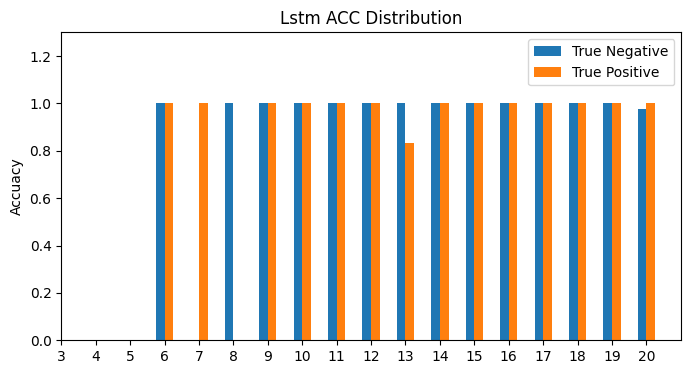

In [ ]:
plt.figure(figsize=(8, 4))

x = np.arange(len(x_label))  # x轴刻度标签位置
width = 0.25  # 柱子的宽度
# 计算每个柱子在x轴上的位置，保证x轴刻度标签居中
# x - width/2，x + width/2即每组数据在x轴上的位置
plt.bar(x - width/2, acc_lstm[0], width, label='True Negative')
plt.bar(x + width/2, acc_lstm[1], width, label='True Positive')
plt.ylabel('Accuacy')
plt.title('2 datasets')
plt.xticks(x, labels=x_label)
plt.ylim(0,1.3)
plt.legend()
plt.title("Lstm ACC Distribution")
plt.savefig("./lstm_distribution.png")

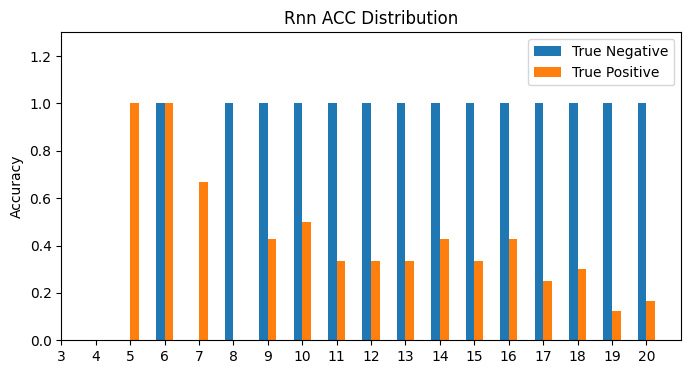

In [ ]:
plt.figure(figsize=(8, 4))

x = np.arange(len(x_label))  # x轴刻度标签位置
width = 0.25  # 柱子的宽度
# 计算每个柱子在x轴上的位置，保证x轴刻度标签居中
# x - width/2，x + width/2即每组数据在x轴上的位置
plt.bar(x - width/2, acc_rnn[0], width, label='True Negative')
plt.bar(x + width/2, acc_rnn[1], width, label='True Positive')
plt.ylabel('Accuracy')
plt.title('2 datasets')
plt.xticks(x, labels=x_label)
plt.ylim(0,1.3)
plt.legend()
plt.title("Rnn ACC Distribution")
plt.savefig("./Rnn_distribution.png")

参数优化：是否进行embedding; hidden_size取50，75，100.。。。。

In [ ]:
!pip install --quiet wandb
import wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 17.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 19.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.1/281.1 kB 24.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 6.1 MB/s eta 0:00:00


In [ ]:
import math
sweep_rnn_config = {
                'method': 'random',
                'metric': {'goal': 'minimize', 'name': 'loss'},
                'parameters': {
                    'nlayers': {'values':[1,2]},
                    'hidsize': {'values':[50,75,100]},
                    'bidirect': {'values': [True,False]},
                    'epochs': {'values': [10,15,20]}
                }
 }

sweep_rnn_id = wandb.sweep(sweep_rnn_config, project="RNN_sweep")

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Create sweep with ID: xvtv7dy0
Sweep URL: https://wandb.ai/adlh5g3/RNN_sweep/sweeps/xvtv7dy0


In [ ]:
def train_rnn_sweep(config=None):
    with wandb.init(project='RNN_sweep_1', config=config):
        config = wandb.config
        net = RNNClassifier(nlayers=config.nlayers, hidsize=config.hidsize, bidirect=config.bidirect)
        loss = nn.CrossEntropyLoss() #自带softmax
        optimizer = optim.Adam(net.parameters(), lr=0.001)

        wandb.watch(net, loss, log="all")

        train_model(model=net, train_loader=trainloader, criterion=loss, optimizer = optimizer, num_epochs=config.epochs)

        _,acc,f1 = eval_model(model=net, test_loader=testloader)
        wandb.log({'f1_val': f1, 'acc_val': acc})
        print('Finished Training')

wandb.agent(sweep_rnn_id, function=train_rnn_sweep, count=15)

wandb: Agent Starting Run: cg5klghv with config:
wandb: 	bidirect: False
wandb: 	epochs: 10
wandb: 	hidsize: 100
wandb: 	nlayers: 2
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch [1/10], Loss: 0.5659
Epoch [2/10], Loss: 0.5795
Epoch [3/10], Loss: 0.5709
Epoch [4/10], Loss: 0.5530
Epoch [5/10], Loss: 0.5620
Epoch [6/10], Loss: 0.5672
Epoch [7/10], Loss: 0.5625
Epoch [8/10], Loss: 0.5841
Epoch [9/10], Loss: 0.5591
Epoch [10/10], Loss: 0.5695
Validation Accuracy: 76.61%
Validation F1 score: 0.00
Finished Training


<ipython-input-105-e0d6967d27da>:24: RuntimeWarning: invalid value encountered in divide
  return accstat/sta, accuracy, f1score


acc_val,▁
f1_val,▁
acc_val,76.60819
f1_val,0.0


wandb: Agent Starting Run: qmshumhj with config:
wandb: 	bidirect: False
wandb: 	epochs: 10
wandb: 	hidsize: 75
wandb: 	nlayers: 2
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch [1/10], Loss: 0.5651
Epoch [2/10], Loss: 0.5402
Epoch [3/10], Loss: 0.5481
Epoch [4/10], Loss: 0.5567
Epoch [5/10], Loss: 0.5467
Epoch [6/10], Loss: 0.5595
Epoch [7/10], Loss: 0.5468
Epoch [8/10], Loss: 0.5380
Epoch [9/10], Loss: 0.5416
Epoch [10/10], Loss: 0.5409
Validation Accuracy: 79.24%
Validation F1 score: 0.20
Finished Training


<ipython-input-105-e0d6967d27da>:24: RuntimeWarning: invalid value encountered in divide
  return accstat/sta, accuracy, f1score


acc_val,▁
f1_val,▁
acc_val,79.23977
f1_val,0.20225


wandb: Agent Starting Run: 0qu39e9k with config:
wandb: 	bidirect: True
wandb: 	epochs: 20
wandb: 	hidsize: 75
wandb: 	nlayers: 1
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch [1/20], Loss: 0.5500
Epoch [2/20], Loss: 0.5474
Epoch [3/20], Loss: 0.5347
Epoch [4/20], Loss: 0.5302
Epoch [5/20], Loss: 0.5298
Epoch [6/20], Loss: 0.5338
Epoch [7/20], Loss: 0.5273
Epoch [8/20], Loss: 0.5362
Epoch [9/20], Loss: 0.5747
Epoch [10/20], Loss: 0.5257
Epoch [11/20], Loss: 0.5319
Epoch [12/20], Loss: 0.5216
Epoch [13/20], Loss: 0.5531
Epoch [14/20], Loss: 0.5283
Epoch [15/20], Loss: 0.5357
Epoch [16/20], Loss: 0.5246
Epoch [17/20], Loss: 0.5333
Epoch [18/20], Loss: 0.5344
Epoch [19/20], Loss: 0.5250
Epoch [20/20], Loss: 0.5264
Validation Accuracy: 80.12%
Validation F1 score: 0.29
Finished Training


<ipython-input-105-e0d6967d27da>:24: RuntimeWarning: invalid value encountered in divide
  return accstat/sta, accuracy, f1score


acc_val,▁
f1_val,▁
acc_val,80.11696
f1_val,0.29167


wandb: Agent Starting Run: 7uuwxujq with config:
wandb: 	bidirect: False
wandb: 	epochs: 15
wandb: 	hidsize: 75
wandb: 	nlayers: 1
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch [1/15], Loss: 0.5466
Epoch [2/15], Loss: 0.5471
Epoch [3/15], Loss: 0.5351
Epoch [4/15], Loss: 0.5266
Epoch [5/15], Loss: 0.5275
Epoch [6/15], Loss: 0.5241
Epoch [7/15], Loss: 0.5181
Epoch [8/15], Loss: 0.5249
Epoch [9/15], Loss: 0.5207
Epoch [10/15], Loss: 0.5248
Epoch [11/15], Loss: 0.5143
Epoch [12/15], Loss: 0.5023
Epoch [13/15], Loss: 0.5148
Epoch [14/15], Loss: 0.5375
Epoch [15/15], Loss: 0.5242
Validation Accuracy: 79.24%
Validation F1 score: 0.20
Finished Training


<ipython-input-105-e0d6967d27da>:24: RuntimeWarning: invalid value encountered in divide
  return accstat/sta, accuracy, f1score


acc_val,▁
f1_val,▁
acc_val,79.23977
f1_val,0.20225


wandb: Agent Starting Run: 74j645w3 with config:
wandb: 	bidirect: True
wandb: 	epochs: 20
wandb: 	hidsize: 75
wandb: 	nlayers: 2
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch [1/20], Loss: 0.5677
Epoch [2/20], Loss: 0.5488
Epoch [3/20], Loss: 0.5644
Epoch [4/20], Loss: 0.5652
Epoch [5/20], Loss: 0.5456
Epoch [6/20], Loss: 0.5461
Epoch [7/20], Loss: 0.5435
Epoch [8/20], Loss: 0.5524
Epoch [9/20], Loss: 0.5561
Epoch [10/20], Loss: 0.5519
Epoch [11/20], Loss: 0.5461
Epoch [12/20], Loss: 0.5622
Epoch [13/20], Loss: 0.5368
Epoch [14/20], Loss: 0.5350
Epoch [15/20], Loss: 0.5276
Epoch [16/20], Loss: 0.5423
Epoch [17/20], Loss: 0.5198
Epoch [18/20], Loss: 0.5025
Epoch [19/20], Loss: 0.4979
Epoch [20/20], Loss: 0.4747
Validation Accuracy: 83.33%
Validation F1 score: 0.45
Finished Training


<ipython-input-105-e0d6967d27da>:24: RuntimeWarning: invalid value encountered in divide
  return accstat/sta, accuracy, f1score


acc_val,▁
f1_val,▁
acc_val,83.33333
f1_val,0.4466


wandb: Agent Starting Run: pbmwvsw2 with config:
wandb: 	bidirect: False
wandb: 	epochs: 15
wandb: 	hidsize: 50
wandb: 	nlayers: 2
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch [1/15], Loss: 0.5448
Epoch [2/15], Loss: 0.5328
Epoch [3/15], Loss: 0.5254
Epoch [4/15], Loss: 0.5196
Epoch [5/15], Loss: 0.5134
Epoch [6/15], Loss: 0.5139
Epoch [7/15], Loss: 0.5181
Epoch [8/15], Loss: 0.5105
Epoch [9/15], Loss: 0.5163
Epoch [10/15], Loss: 0.5071
Epoch [11/15], Loss: 0.5047
Epoch [12/15], Loss: 0.5113
Epoch [13/15], Loss: 0.5108
Epoch [14/15], Loss: 0.5024
Epoch [15/15], Loss: 0.4941
Validation Accuracy: 81.58%
Validation F1 score: 0.35
Finished Training


<ipython-input-105-e0d6967d27da>:24: RuntimeWarning: invalid value encountered in divide
  return accstat/sta, accuracy, f1score


acc_val,▁
f1_val,▁
acc_val,81.57895
f1_val,0.35052


wandb: Agent Starting Run: ss339x5z with config:
wandb: 	bidirect: False
wandb: 	epochs: 20
wandb: 	hidsize: 100
wandb: 	nlayers: 2
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch [1/20], Loss: 0.5590
Epoch [2/20], Loss: 0.5595
Epoch [3/20], Loss: 0.5628
Epoch [4/20], Loss: 0.5638
Epoch [5/20], Loss: 0.5804
Epoch [6/20], Loss: 0.5631
Epoch [7/20], Loss: 0.5633
Epoch [8/20], Loss: 0.5626
Epoch [9/20], Loss: 0.5481
Epoch [10/20], Loss: 0.5582
Epoch [11/20], Loss: 0.5534
Epoch [12/20], Loss: 0.5644
Epoch [13/20], Loss: 0.5664
Epoch [14/20], Loss: 0.5626
Epoch [15/20], Loss: 0.5521
Epoch [16/20], Loss: 0.5460
Epoch [17/20], Loss: 0.5366
Epoch [18/20], Loss: 0.5455
Epoch [19/20], Loss: 0.5508
Epoch [20/20], Loss: 0.5432
Validation Accuracy: 78.36%
Validation F1 score: 0.37
Finished Training


<ipython-input-105-e0d6967d27da>:24: RuntimeWarning: invalid value encountered in divide
  return accstat/sta, accuracy, f1score


acc_val,▁
f1_val,▁
acc_val,78.36257
f1_val,0.37288


wandb: Agent Starting Run: 3e5xgzxr with config:
wandb: 	bidirect: True
wandb: 	epochs: 15
wandb: 	hidsize: 100
wandb: 	nlayers: 2
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch [1/15], Loss: 0.5978
Epoch [2/15], Loss: 0.6159
Epoch [3/15], Loss: 0.5842
Epoch [4/15], Loss: 0.6053
Epoch [5/15], Loss: 0.5981
Epoch [6/15], Loss: 0.6130
Epoch [7/15], Loss: 0.5674
Epoch [8/15], Loss: 0.5860
Epoch [9/15], Loss: 0.5957
Epoch [10/15], Loss: 0.5902
Epoch [11/15], Loss: 0.5671
Epoch [12/15], Loss: 0.5987
Epoch [13/15], Loss: 0.6045
Epoch [14/15], Loss: 0.5896
Epoch [15/15], Loss: 0.5952
Validation Accuracy: 78.36%
Validation F1 score: 0.14
Finished Training


<ipython-input-105-e0d6967d27da>:24: RuntimeWarning: invalid value encountered in divide
  return accstat/sta, accuracy, f1score


acc_val,▁
f1_val,▁
acc_val,78.36257
f1_val,0.13953


wandb: Agent Starting Run: n8mv210q with config:
wandb: 	bidirect: True
wandb: 	epochs: 20
wandb: 	hidsize: 50
wandb: 	nlayers: 1
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch [1/20], Loss: 0.5430
Epoch [2/20], Loss: 0.5270
Epoch [3/20], Loss: 0.5183
Epoch [4/20], Loss: 0.5014
Epoch [5/20], Loss: 0.5091
Epoch [6/20], Loss: 0.5223
Epoch [7/20], Loss: 0.5350
Epoch [8/20], Loss: 0.5269
Epoch [9/20], Loss: 0.5143
Epoch [10/20], Loss: 0.5048
Epoch [11/20], Loss: 0.4894
Epoch [12/20], Loss: 0.4708
Epoch [13/20], Loss: 0.4814
Epoch [14/20], Loss: 0.4668
Epoch [15/20], Loss: 0.4563
Epoch [16/20], Loss: 0.4438
Epoch [17/20], Loss: 0.4201
Epoch [18/20], Loss: 0.4598
Epoch [19/20], Loss: 0.4554
Epoch [20/20], Loss: 0.4267
Validation Accuracy: 85.96%
Validation F1 score: 0.59
Finished Training


<ipython-input-105-e0d6967d27da>:24: RuntimeWarning: invalid value encountered in divide
  return accstat/sta, accuracy, f1score


acc_val,▁
f1_val,▁
acc_val,85.96491
f1_val,0.58621


wandb: Agent Starting Run: xi16jxeg with config:
wandb: 	bidirect: True
wandb: 	epochs: 15
wandb: 	hidsize: 75
wandb: 	nlayers: 2
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch [1/15], Loss: 0.5824
Epoch [2/15], Loss: 0.5869
Epoch [3/15], Loss: 0.5632
Epoch [4/15], Loss: 0.5998
Epoch [5/15], Loss: 0.5909
Epoch [6/15], Loss: 0.5993
Epoch [7/15], Loss: 0.5694
Epoch [8/15], Loss: 0.5746
Epoch [9/15], Loss: 0.5829
Epoch [10/15], Loss: 0.5772
Epoch [11/15], Loss: 0.5690
Epoch [12/15], Loss: 0.5505
Epoch [13/15], Loss: 0.5682
Epoch [14/15], Loss: 0.5696
Epoch [15/15], Loss: 0.5375
Validation Accuracy: 77.78%
Validation F1 score: 0.10
Finished Training


<ipython-input-105-e0d6967d27da>:24: RuntimeWarning: invalid value encountered in divide
  return accstat/sta, accuracy, f1score


acc_val,▁
f1_val,▁
acc_val,77.77778
f1_val,0.09524


wandb: Agent Starting Run: zhh1ioqn with config:
wandb: 	bidirect: False
wandb: 	epochs: 10
wandb: 	hidsize: 50
wandb: 	nlayers: 2
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch [1/10], Loss: 0.5463
Epoch [2/10], Loss: 0.5309
Epoch [3/10], Loss: 0.5212
Epoch [4/10], Loss: 0.5221
Epoch [5/10], Loss: 0.5177
Epoch [6/10], Loss: 0.5325
Epoch [7/10], Loss: 0.5264
Epoch [8/10], Loss: 0.5220
Epoch [9/10], Loss: 0.5200
Epoch [10/10], Loss: 0.5197
Validation Accuracy: 79.24%
Validation F1 score: 0.20
Finished Training


<ipython-input-105-e0d6967d27da>:24: RuntimeWarning: invalid value encountered in divide
  return accstat/sta, accuracy, f1score


acc_val,▁
f1_val,▁
acc_val,79.23977
f1_val,0.20225


wandb: Agent Starting Run: q19pckf0 with config:
wandb: 	bidirect: False
wandb: 	epochs: 20
wandb: 	hidsize: 75
wandb: 	nlayers: 2
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch [1/20], Loss: 0.5553
Epoch [2/20], Loss: 0.5377
Epoch [3/20], Loss: 0.5266
Epoch [4/20], Loss: 0.5239
Epoch [5/20], Loss: 0.5427
Epoch [6/20], Loss: 0.5427
Epoch [7/20], Loss: 0.5464
Epoch [8/20], Loss: 0.5319
Epoch [9/20], Loss: 0.5390
Epoch [10/20], Loss: 0.5272
Epoch [11/20], Loss: 0.5117
Epoch [12/20], Loss: 0.5133
Epoch [13/20], Loss: 0.4892
Epoch [14/20], Loss: 0.4875
Epoch [15/20], Loss: 0.4812
Epoch [16/20], Loss: 0.4709
Epoch [17/20], Loss: 0.4968
Epoch [18/20], Loss: 0.5114
Epoch [19/20], Loss: 0.4737
Epoch [20/20], Loss: 0.4832
Validation Accuracy: 81.58%
Validation F1 score: 0.35
Finished Training


<ipython-input-105-e0d6967d27da>:24: RuntimeWarning: invalid value encountered in divide
  return accstat/sta, accuracy, f1score


acc_val,▁
f1_val,▁
acc_val,81.57895
f1_val,0.35052


wandb: Agent Starting Run: p0puqtq2 with config:
wandb: 	bidirect: False
wandb: 	epochs: 20
wandb: 	hidsize: 75
wandb: 	nlayers: 2
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch [1/20], Loss: 0.5524
Epoch [2/20], Loss: 0.5337
Epoch [3/20], Loss: 0.5307
Epoch [4/20], Loss: 0.5250
Epoch [5/20], Loss: 0.5246
Epoch [6/20], Loss: 0.5250
Epoch [7/20], Loss: 0.5434
Epoch [8/20], Loss: 0.5353
Epoch [9/20], Loss: 0.5273
Epoch [10/20], Loss: 0.5266
Epoch [11/20], Loss: 0.5442
Epoch [12/20], Loss: 0.5299
Epoch [13/20], Loss: 0.5150
Epoch [14/20], Loss: 0.5289
Epoch [15/20], Loss: 0.5197
Epoch [16/20], Loss: 0.5206
Epoch [17/20], Loss: 0.5132
Epoch [18/20], Loss: 0.5184
Epoch [19/20], Loss: 0.4976
Epoch [20/20], Loss: 0.4972
Validation Accuracy: 81.58%
Validation F1 score: 0.35
Finished Training


<ipython-input-105-e0d6967d27da>:24: RuntimeWarning: invalid value encountered in divide
  return accstat/sta, accuracy, f1score


acc_val,▁
f1_val,▁
acc_val,81.57895
f1_val,0.35052


wandb: Agent Starting Run: tdgd8cob with config:
wandb: 	bidirect: True
wandb: 	epochs: 15
wandb: 	hidsize: 100
wandb: 	nlayers: 1
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch [1/15], Loss: 0.5662
Epoch [2/15], Loss: 0.5473
Epoch [3/15], Loss: 0.5493
Epoch [4/15], Loss: 0.5377
Epoch [5/15], Loss: 0.5298
Epoch [6/15], Loss: 0.5343
Epoch [7/15], Loss: 0.5127
Epoch [8/15], Loss: 0.4859
Epoch [9/15], Loss: 0.4787
Epoch [10/15], Loss: 0.4918
Epoch [11/15], Loss: 0.4756
Epoch [12/15], Loss: 0.4441
Epoch [13/15], Loss: 0.4207
Epoch [14/15], Loss: 0.4185
Epoch [15/15], Loss: 0.4619
Validation Accuracy: 84.21%
Validation F1 score: 0.58
Finished Training


<ipython-input-105-e0d6967d27da>:24: RuntimeWarning: invalid value encountered in divide
  return accstat/sta, accuracy, f1score


acc_val,▁
f1_val,▁
acc_val,84.21053
f1_val,0.58462


wandb: Agent Starting Run: smjt53ic with config:
wandb: 	bidirect: True
wandb: 	epochs: 10
wandb: 	hidsize: 100
wandb: 	nlayers: 1
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch [1/10], Loss: 0.5642
Epoch [2/10], Loss: 0.5609
Epoch [3/10], Loss: 0.5553
Epoch [4/10], Loss: 0.5630
Epoch [5/10], Loss: 0.5515
Epoch [6/10], Loss: 0.5474
Epoch [7/10], Loss: 0.5394
Epoch [8/10], Loss: 0.5503
Epoch [9/10], Loss: 0.5485
Epoch [10/10], Loss: 0.5423
Validation Accuracy: 80.12%
Validation F1 score: 0.26
Finished Training


<ipython-input-105-e0d6967d27da>:24: RuntimeWarning: invalid value encountered in divide
  return accstat/sta, accuracy, f1score


acc_val,▁
f1_val,▁
acc_val,80.11696
f1_val,0.26087


泛化能力评估：长度21-50

In [6]:
#自定义一个Dataset类，必需包含init, len, getitem
class CustomDataset(Dataset):
    def __init__(self):
        self.data = []
        self.targets = []

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        return self.data[index], self.targets[index]

    def append(self, data, target):
        self.data.append(data)
        self.targets.append(target)


In [8]:
stats_general = np.zeros((2,30))
print(stats_general)

# 创建自定义数据集对象
dataset_general = CustomDataset()
sum = 0
k=0
# 逐个添加数据和标签
for x in range(1,50):
  for y in range(1,50):
    for z in range(1,50):
     if x+y+z<21 or x+y+z>50:
       continue
     input_string = 'a'*x + 'b'*y + 'c'*z
     sum+=1
     input_array = np.array(list(input_string)).reshape(-1, 1)
     #创建并适配 OneHotEncoder
     encoder = OneHotEncoder(sparse_output=False)
     data = torch.FloatTensor(encoder.fit_transform(input_array))
     if x==y or y==z or x==z :
      target=torch.tensor(1)
      k+=1
      stats_general[1][x+y+z-21] += 1
     else:
      target=torch.tensor(0)
      stats_general[0][x+y+z-21] += 1
     dataset_general.append(data, target)

print(sum,k)

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0.]]
18460 1510


In [19]:
from torch.utils.data import SubsetRandomSampler

np.random.seed(42)

# 指定抽样的索引数量
sample_size = 5000
indices = np.random.choice(len(dataset_general), sample_size, replace=False)
sampler = SubsetRandomSampler(indices)

# 创建 DataLoader
general_dataloader = DataLoader(dataset_general, sampler=sampler, batch_size=1)

print(len(general_dataloader))


5000


In [26]:
def eval_general_model(model,test_loader):
    model.eval()
    input = torch.tensor([])
    target = torch.tensor([])
    accstat = np.zeros((2,30))
    sta = np.zeros((2,30))
    with torch.no_grad():
      for texts, labels in test_loader:
          outputs = model(texts)
          predicted = torch.argmax(outputs,1)
          sta[labels.item()][texts.size(1)-21]+=1
          if predicted == labels:
            accstat[labels.item()][texts.size(1)-21]+=1
          input = torch.cat((input,predicted))
          target = torch.cat((target,labels))
    input = input.numpy()
    target = target.numpy()
    accuracy = 100 * (input == target).sum() / len(target)
   ## recall = binary_recall(input, target)
    f1score = f1_score(y_pred=input,y_true=target)
    print(f'Validation Accuracy: {accuracy:.2f}%')
    print(f'Validation F1 score: {f1score:.2f}')
    #sta里会有爆零的可能
    return accstat/sta, accuracy, f1score

In [27]:
model_rnn.load_state_dict(torch.load("./model_rnn1.pth"))
#通过 load_state_dict 函数加载参数，torch.load() 函数中重要的一步是反序列化。
model_lstm.load_state_dict(torch.load("./model_lstm1.pth"))

acc_rnn,_,_ = eval_general_model(model_rnn,general_dataloader)
acc_lstm,_,_ = eval_general_model(model_lstm,general_dataloader)

Validation Accuracy: 92.04%
Validation F1 score: 0.14
Validation Accuracy: 95.10%
Validation F1 score: 0.72


In [28]:
x_general_label = list()
for x in range(21,51):
  x_general_label.append(str(x))

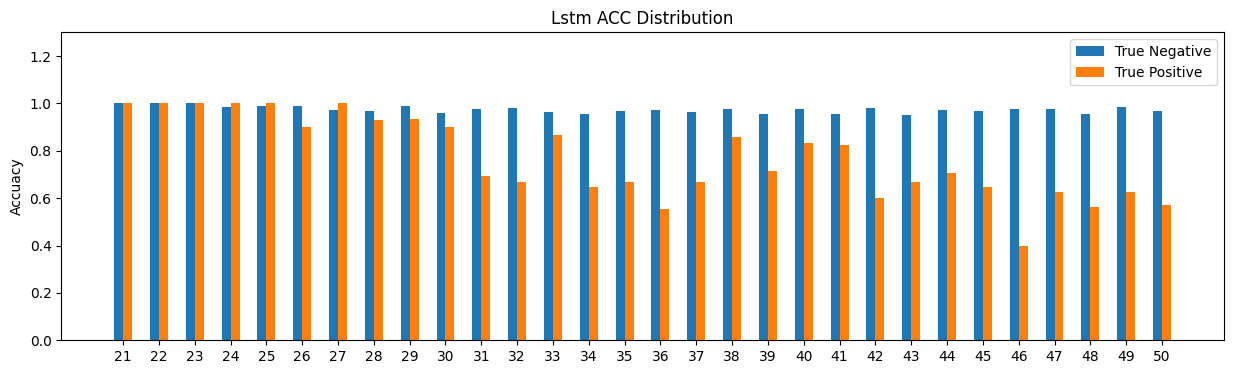

In [30]:
plt.figure(figsize=(15, 4))

x = np.arange(len(x_general_label))  # x轴刻度标签位置
width = 0.25  # 柱子的宽度
# 计算每个柱子在x轴上的位置，保证x轴刻度标签居中
# x - width/2，x + width/2即每组数据在x轴上的位置
plt.bar(x - width/2, acc_lstm[0], width, label='True Negative')
plt.bar(x + width/2, acc_lstm[1], width, label='True Positive')
plt.ylabel('Accuacy')
plt.xticks(x, labels=x_general_label)
plt.ylim(0,1.3)
plt.legend()
plt.title("Lstm ACC Distribution")
plt.savefig("./lstm_general_distribution.png")

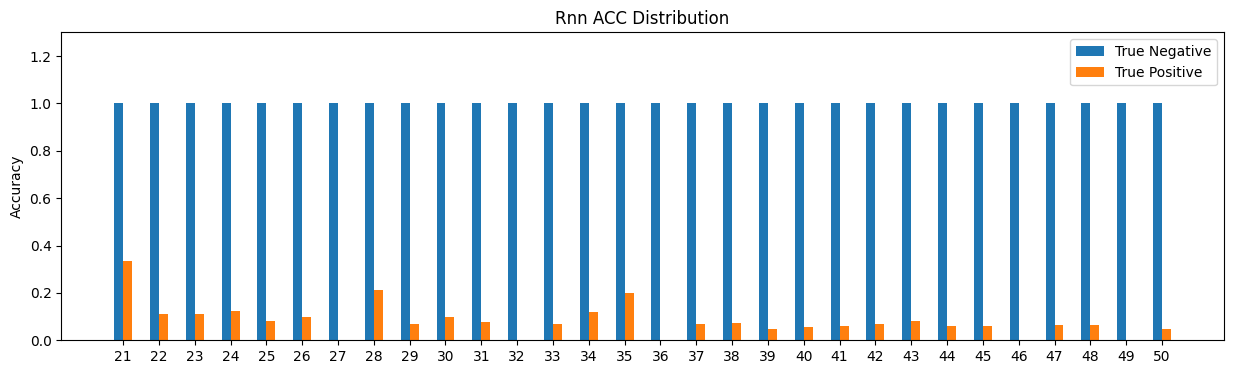

In [32]:
plt.figure(figsize=(15, 4))

x = np.arange(len(x_general_label))  # x轴刻度标签位置
width = 0.25  # 柱子的宽度
# 计算每个柱子在x轴上的位置，保证x轴刻度标签居中
# x - width/2，x + width/2即每组数据在x轴上的位置
plt.bar(x - width/2, acc_rnn[0], width, label='True Negative')
plt.bar(x + width/2, acc_rnn[1], width, label='True Positive')
plt.ylabel('Accuracy')
plt.xticks(x, labels=x_general_label)
plt.ylim(0,1.3)
plt.legend()
plt.title("Rnn ACC Distribution")
plt.savefig("./Rnn_general_distribution.png")